# White Blood Cells Classification

## Load dependencies

In [1]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import os
from glob import glob

import seaborn as sns
sns.set_style('darkgrid')

## Load and explore dataset

In [2]:
DATASET_DIR = "../input/blood-cells-image-dataset/bloodcells_dataset"
CLASS_NAMES = os.listdir(DATASET_DIR)
NUM_CLASSES = len(CLASS_NAMES)

In [3]:
batch_size = 32
epochs = 10
img_height = 64
img_width = 64

In [4]:
# Import image dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Dataset autotune
AUTOTUNE = tf.data.AUTOTUNE
train_ds_tuned = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_tuned = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


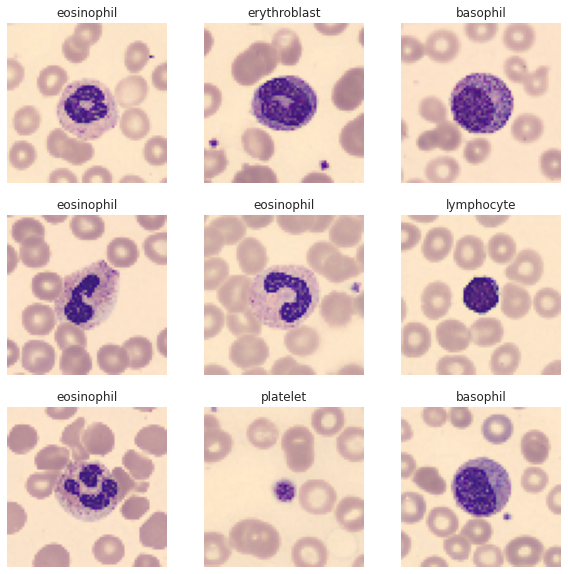

In [5]:
# Show dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")
plt.show()

## Set up the model 

In [6]:
augment = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
])

model = tf.keras.Sequential([
    augment,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES)
    ])

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


model.build(input_shape=(0, img_width, img_height, 3))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (0, 64, 64, 3)            0         
_________________________________________________________________
conv2d (Conv2D)              (0, 62, 62, 32)           896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (0, 31, 31, 32)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (0, 29, 29, 32)           9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (0, 14, 14, 32)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (0, 12, 12, 32)           9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (0, 6, 6, 32)            

In [7]:
history = model.fit(
  train_ds_tuned,
  validation_data=val_ds_tuned,
  epochs=epochs
)

Epoch 1/10
428/428 [==============================] - 41s 90ms/step - loss: 1.1438 - accuracy: 0.5663 - val_loss: 0.9787 - val_accuracy: 0.6302
Epoch 2/10
428/428 [==============================] - 25s 58ms/step - loss: 0.6594 - accuracy: 0.7582 - val_loss: 0.7452 - val_accuracy: 0.7317
Epoch 3/10
428/428 [==============================] - 25s 59ms/step - loss: 0.4948 - accuracy: 0.8184 - val_loss: 0.5969 - val_accuracy: 0.7923
Epoch 4/10
428/428 [==============================] - 25s 58ms/step - loss: 0.4082 - accuracy: 0.8551 - val_loss: 0.4235 - val_accuracy: 0.8505
Epoch 5/10
428/428 [==============================] - 25s 58ms/step - loss: 0.3541 - accuracy: 0.8750 - val_loss: 0.3937 - val_accuracy: 0.8640
Epoch 6/10
428/428 [==============================] - 25s 58ms/step - loss: 0.3057 - accuracy: 0.8934 - val_loss: 0.3262 - val_accuracy: 0.8800
Epoch 7/10
428/428 [==============================] - 25s 58ms/step - loss: 0.2792 - accuracy: 0.9008 - val_loss: 0.4739 - val_accuracy:

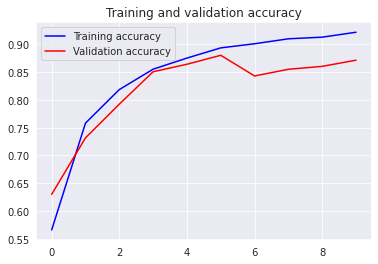

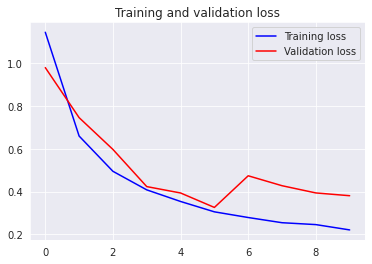

In [8]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(epochs), accuracy, 'b', label='Training accuracy')
plt.plot(range(epochs), val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(range(epochs), loss, 'b', label='Training loss')
plt.plot(range(epochs), val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## Make some predictions

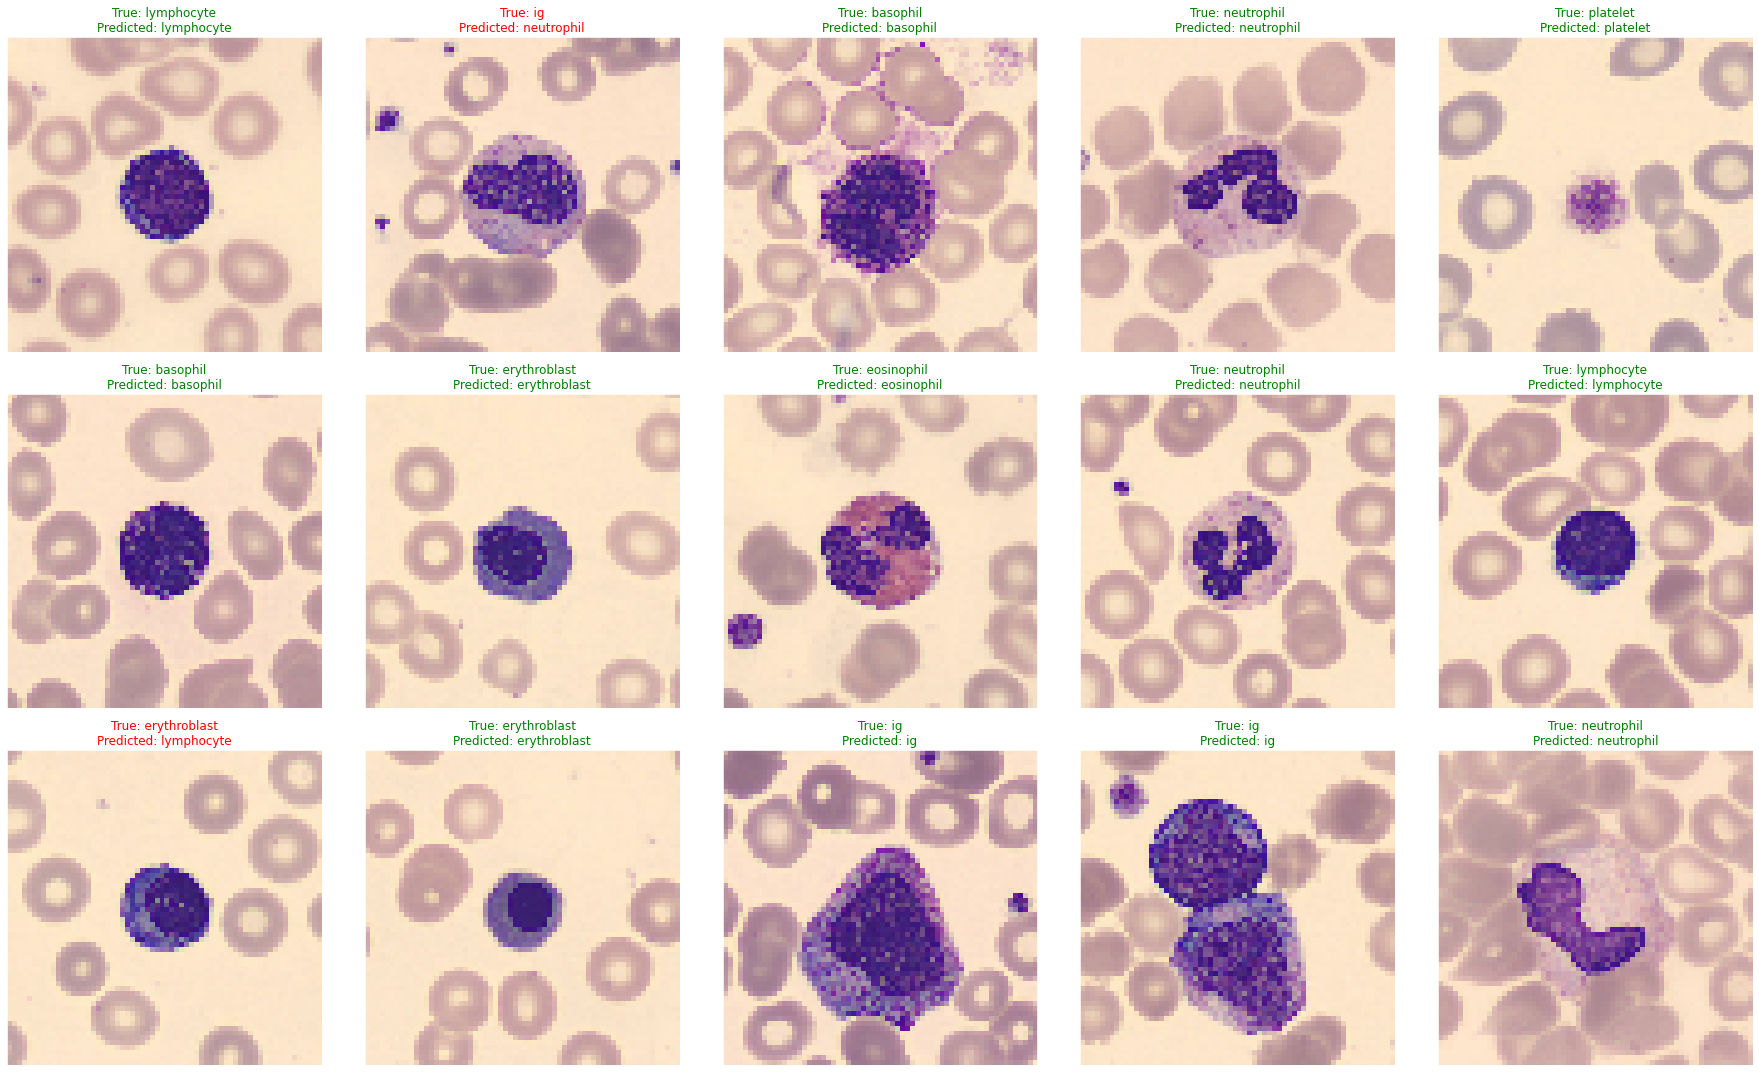

In [9]:
CLASS_NAMES = train_ds.class_names
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
for images, labels in train_ds.take(1):
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy().astype("uint8"))
        img = images[i].numpy().astype("uint8")
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        prediction_label = CLASS_NAMES[np.argmax(score)]
        correct_label = CLASS_NAMES[labels[i]]
        if prediction_label == correct_label:
            color = "green"
        else:
            color = "red"
        ax.set_title(f"True: {correct_label}\nPredicted: {prediction_label}", color=color)
plt.tight_layout()
plt.show()